# Disaggregation

In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

/home/ayush/anaconda3/envs/n2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ayush/anaconda3/envs/n2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ayush/anaconda3/envs/n2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ayush/anaconda3/envs/n2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/ayush/anaconda3/envs/n2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, m

### Dividing data into train and test set

In [2]:
train = DataSet('/data/REDD/redd.h5')
test = DataSet('/data/REDD/redd.h5')

/home/ayush/nilm_metadata/nilm_metadata/file_management.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  objs = yaml.load(fh)


Let us use building 1 for demo purposes

In [3]:
building = 1

Let's split data at April 30th

In [4]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


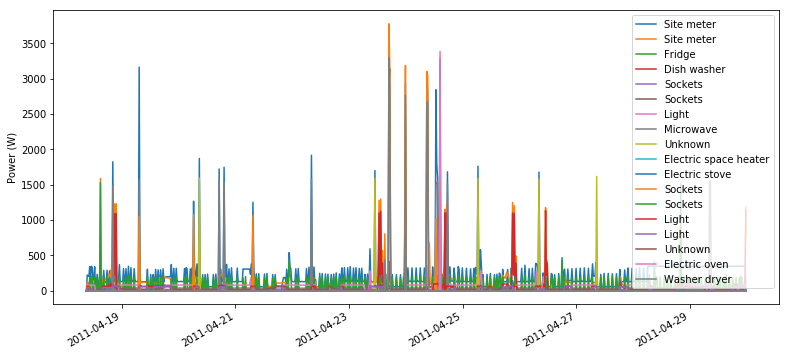

In [5]:
train_elec.plot()

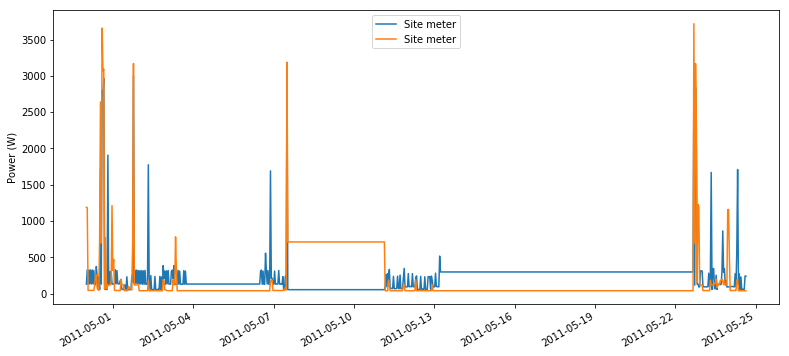

In [6]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [7]:
fridge_meter = train_elec['fridge']

In [8]:
fridge_df = next(fridge_meter.load())

In [9]:
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,6.0
2011-04-18 09:22:16-04:00,6.0
2011-04-18 09:22:20-04:00,6.0
2011-04-18 09:22:23-04:00,6.0
2011-04-18 09:22:26-04:00,6.0


In [10]:
mains = train_elec.mains()

In [11]:
mains_df = next(mains.load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [12]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [13]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

2/16 ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])

/nilmtk/nilmtk/stats/totalenergyresults.py:41: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return self._data.fillna(0).convert_objects()


15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [14]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)

### Training and disaggregation

#### FHMM

In [15]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Runtime = 2.76029896736145 seconds.


In [16]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = next(meter.load(sample_period=60))
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [17]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [18]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [19]:
local_timezone = train.metadata['timezone']

In [20]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [21]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [22]:
gt_overall.head()

,"ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])","ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])","ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])","ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])"
2011-04-30 00:01:00-04:00,1131.0,76.0,6.0,31.0,4.0
2011-04-30 00:02:00-04:00,1128.0,76.0,6.0,29.0,4.0
2011-04-30 00:03:00-04:00,1133.0,76.0,6.0,28.0,4.0
2011-04-30 00:04:00-04:00,1129.0,77.0,6.0,28.0,4.0
2011-04-30 00:05:00-04:00,1130.0,76.0,6.0,28.0,4.0


Using prettier names!

In [23]:
appliance_labels = [m for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [24]:
pred_overall.head()

,Dish washer,Light,Fridge,Sockets,Microwave
2011-04-30 00:01:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:02:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:03:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:04:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:05:00-04:00,0.0,2.0,194.0,22.0,1098.0


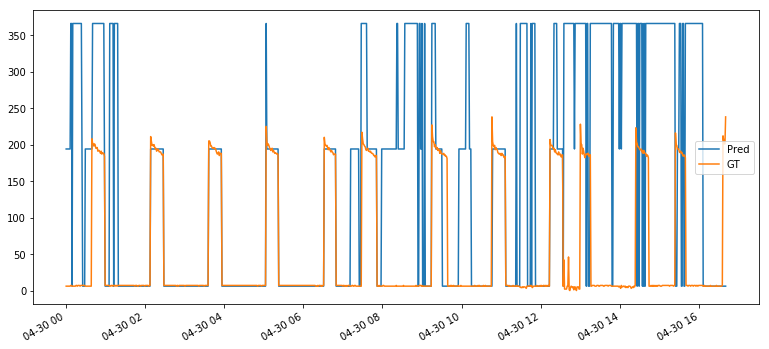

In [25]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [28]:
pd.Series(rms_error)

Dish washer    182.148235
Fridge         174.803628
Light           92.915403
Microwave      177.634751
Sockets         46.909119
dtype: float64

#### CO

In [ ]:
co = CombinatorialOptimisation()
co.train(train_elec)

In [6]:
for model in co.model:
    print_dict(model)

In [7]:
# Disaggregate
disag_filename = '/data/REDD/redd-disag.h5'
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(train_elec.mains(), output)
output.close()

/home/ayush/nilmtk/nilmtk/metergroup.py:922: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/home/ayush/nilmtk/nilmtk/datastore/hdfdatastore.py:128: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  stop=look_ahead_end_i)


Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/tables-3.5.1-py3.6-linux-x86_64.egg/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'meter(3, 4)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/tables-3.5.1-py3.6-linux-x86_64.egg/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'meter(10, 20)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])'
Estimating power demand f

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])'
Estimating power demand f

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'Elec

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])'
Estimating power demand f

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='REDD',

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'Elec

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.


## Examine disaggregated data

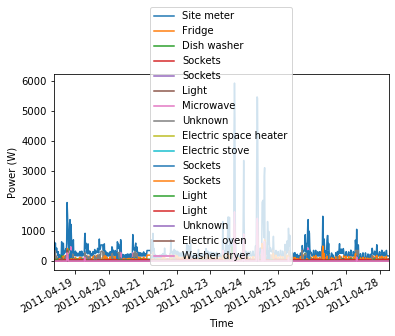

In [9]:
disag = DataSet(disag_filename)
disag_elec = disag.buildings[1].elec
disag_elec.plot()
plt.xlabel("Time")
disag.store.close()

## Calculate accuracy of disaggregation

/home/ayush/nilmtk/nilmtk/datastore/hdfdatastore.py:128: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  stop=look_ahead_end_i)
/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/scikit_learn-0.19.2-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ayush/anaconda3/envs/n2/lib/python3.6/site-packages/scikit_learn-0.19.2-py3.6-linux-x86_64.egg/sklearn/met

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     

/home/ayush/nilmtk/nilmtk/metergroup.py:1776: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cumulator_arr = cumulator.as_matrix()



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     

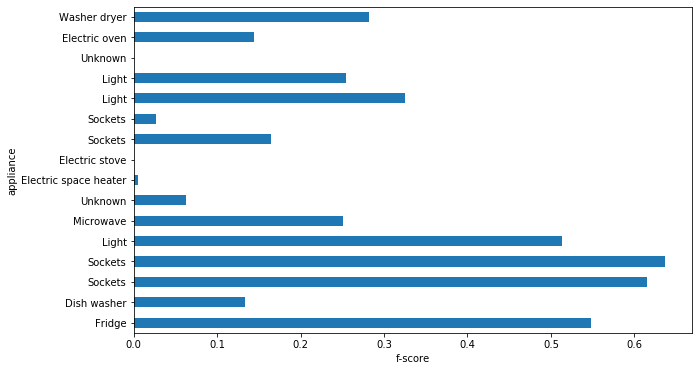

In [12]:
disag = DataSet(disag_filename)
disag_elec = disag.buildings[1].elec

f1 = f1_score(disag_elec, train_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh', figsize=(10,6))
plt.ylabel('appliance');
plt.xlabel('f-score');

disag.store.close()